## Import Libraries and Declare API Key

In [55]:
import requests
import pandas as pd
import numpy as np
import signal
import matplotlib.pyplot as plt

In [56]:
API_KEY = {'X-API-key': 'RPCJTKLW'}

## Accesing the Past Heat History

### Historical Data Retrieval

In [57]:
df_ngn = None
df_whel = None
df_gear = None
df_rsm = None

with requests.Session() as s:
    s.headers.update(API_KEY)
    resp1 = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'NGN'})
    resp2 = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'WHEL'})
    resp3 = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'GEAR'})
    resp4 = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'RSM1000'})
    if resp1.ok and resp2.ok and resp3.ok and resp4.ok:
        book1 = resp1.json()
        book2 = resp2.json()
        book3 = resp3.json()
        book4 = resp4.json()
        df_ngn = pd.DataFrame(book1)
        df_whel = pd.DataFrame(book2)
        df_gear = pd.DataFrame(book3)
        df_rsm = pd.DataFrame(book4)
    else:
        print('request denied.')

In [58]:
df_gear

,tick,open,high,low,close
0,101,24.34,24.34,24.34,24.34
1,100,24.31,24.34,24.31,24.34
2,99,24.32,24.32,24.31,24.31
3,98,24.38,24.38,24.32,24.32
4,97,24.57,24.57,24.38,24.38
...,...,...,...,...,...
96,5,24.96,24.96,24.88,24.88
97,4,25.12,25.12,24.96,24.96
98,3,25.12,25.12,25.12,25.12
99,2,25.04,25.13,25.04,25.12


In [59]:
df_rsm.iloc[::-1]

,tick,open,high,low,close
100,1,100.00,100.02,100.00,100.02
99,2,100.02,100.02,99.02,99.02
98,3,99.02,99.28,99.02,99.28
97,4,99.28,99.66,99.28,99.66
96,5,99.66,99.87,99.66,99.87
...,...,...,...,...,...
4,97,103.22,104.04,103.22,104.04
3,98,104.04,104.34,104.04,104.34
2,99,104.34,104.96,104.34,104.96
1,100,104.96,104.96,104.89,104.89


In [60]:
import talib

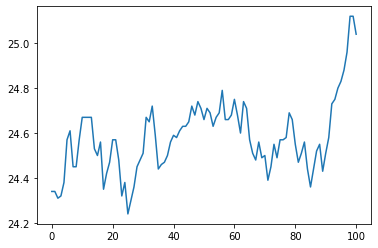

In [63]:
macd, macdsignal, macdhist = talib.MACD(df_gear['close'].values, 5 , 12, 5)
plt.plot(df_gear['close'].values)

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan -0.03871403 -0.02961656 -0.04805861
 -0.0392215  -0.02343442 -0.00148376  0.00690452 -0.00220043 -0.02458826
 -0.02120794 -0.03231285 -0.02238803 -0.00595326  0.01367136  0.02356004
  0.02760971  0.04382024  0.03940698  0.0381255   0.01366844 -0.01774129
 -0.02548292 -0.02369517 -0.01584639 -0.00326639  0.00530102  0.00594474
  0.00817778  0.00927134  0.00718844  0.00655512  0.01245147  0.00636985
  0.00873221  0.00292756 -0.00734979 -0.00537307 -0.00742701 -0.01528746
 -0.01169357 -0.00663039  0.00776255 -0.00457328 -0.00911311 -0.00735733
  0.00255957 -0.00303024 -0.01459312  0.00024735  0.00200751 -0.01466407
 -0.02545158 -0.02806526 -0.01349374 -0.01279288 -0.00764279 -0.0159722
 -0.00726088  0.01120578  0.01068974  0.01969694  0.0207595   0.01948533
  0.02919382  0.02403882  0.00423581 -0.01400413 -0.

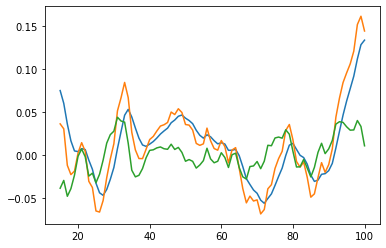

In [64]:
plt.plot(macdsignal)
plt.plot(macd)
plt.plot(macdhist)
print(macdhist)

In [8]:
pd_new = pd.concat([df_rsm['close'].rename('RSM1000'), df_gear['close'].rename('GEAR')
                    , df_whel['close'].rename('WHEL'), df_ngn['close'].rename('NGN')], axis = 1)
pd_new = pd_new.iloc[::-1]
pd_new

,RSM1000,GEAR,WHEL,NGN
299,98.77,25.46,24.56,25.47
298,97.79,25.83,24.20,25.78
297,97.99,25.68,24.26,25.74
296,98.10,25.65,24.32,25.65
295,98.65,25.47,24.53,25.37
...,...,...,...,...
4,110.63,21.66,28.57,21.41
3,110.20,21.75,28.41,21.57
2,110.33,21.77,28.42,21.52
1,111.02,21.47,28.65,21.27


### Observed Historical Correlation

In [9]:
 corr_df = pd_new.corr(method='pearson')
 #reset symbol as index (rather than 0-X)
 corr_df.head().reset_index()
 corr_df.head(10)
corr_df.style.set_caption("Observed Historical Correlation")

,RSM1000,GEAR,WHEL,NGN
RSM1000,1.000000,-0.983630,0.993338,-0.988794
GEAR,-0.983630,1.000000,-0.978415,0.982953
WHEL,0.993338,-0.978415,1.000000,-0.972571
NGN,-0.988794,0.982953,-0.972571,1.000000


### Observed Historical Volatillity

In [10]:
def volatility(data):
    data['Log returns'] = np.log(data['close']/data['close'].shift())
    volatility = data['Log returns'].std()*1200**.5
    return volatility

In [11]:
lst = [[volatility(df_rsm), volatility(df_gear), volatility(df_whel), volatility(df_ngn)]]
df_vol = pd.DataFrame(lst, columns =['RSM1000', 'GEAR', 'WHEL', 'NGN'])
df_vol.style.set_caption("Observed Historical Volatillity")

,RSM1000,GEAR,WHEL,NGN
0,0.150262,0.238427,0.220240,0.237979


### Observed Historical Beta

In [12]:
def market_beta(name):
    data = None
    if name == 'NGN':
        data = df_ngn
    elif name == 'WHEL':
        data = df_whel
    else:
        data = df_gear
        
    df_rsm['Log returns'] = np.log(df_rsm['close']/df_rsm['close'].shift())
    data['Log returns'] = np.log(data['close']/data['close'].shift())
    
    beta = corr_df['RSM1000'][name] * (data['Log returns'].std() / df_rsm['Log returns'].std())
    return beta  

In [13]:
lst = [[market_beta('GEAR'), market_beta('WHEL'), market_beta('NGN')]]
df_bet = pd.DataFrame(lst, columns =['GEAR', 'WHEL', 'NGN'])
df_bet.style.set_caption("Observed Historical Beta")

,GEAR,WHEL,NGN
0,-1.560771,1.455943,-1.566015


## Current Heat Trading Algorithm

### Basic Buy and Sell Functions

In [18]:
shutdown = False

class ApiException(Exception):
    pass

def signal_handler(signum, frame):
    global shutdown
    signal.signal(signal.SIGINT, signal.SIG_DFL)
    shutdown = True

def get_tick(session):
    resp = session.get('http://localhost:9999/v1/case')
    if resp.ok:
        case = resp.json()
        return case['tick']
    raise ApiException('Authorization error. Please check API key.')

def ticker_bid_ask(session, ticker):
    payload = {'ticker': ticker}
    resp = session.get('http://localhost:9999/v1/securities/book', params = payload)
    if resp.ok:
        book = resp.json()
        return book['bids'][0]['price'], book['asks'][0]['price']
    raise ApiException('Authorization error. Please check API key.')

def buy(session, ticker, type, q, price = None):
    if type == 'MARKET':
        resp = session.post('http://localhost:9999/v1/orders', params = {'ticker': ticker, 'type': 'MARKET', 'quantity': q, 'action': 'BUY'})
        if resp.ok:
            mkt_order = resp.json()
            id = mkt_order['order_id']
            print('The market buy order was submitted and has ID', id)
        else:
            print('The order was not successfully submitted!')
    else:
        resp = session.post('http://localhost:9999/v1/orders',
                            params={'ticker': ticker, 'type': 'LIMIT', 'quantity': q, 'action': 'BUY', 'price': price})
        if resp.ok:
            mkt_order = resp.json()
            id = mkt_order['order_id']
            print('The market buy order was submitted and has ID', id)
        else:
            print('The order was not successfully submitted!')

def sell(session, ticker, type, q, price = None):
    if type == 'MARKET':
        resp = session.post('http://localhost:9999/v1/orders', params = {'ticker': ticker, 'type': 'MARKET', 'quantity': q, 'action': 'SELL'})
        if resp.ok:
            mkt_order = resp.json()
            id = mkt_order['order_id']
            print('The market buy order was submitted and has ID', id)
        else:
            print('The order was not successfully submitted!')
    else:
        resp = session.post('http://localhost:9999/v1/orders',
                            params={'ticker': ticker, 'type': 'LIMIT', 'quantity': q, 'action': 'SELL', 'price': price})
        if resp.ok:
            mkt_order = resp.json()
            id = mkt_order['order_id']
            print('The market buy order was submitted and has ID', id)
        else:
            print('The order was not successfully submitted!')

def cancel(session, order_id):
    order_id = order_id # assuming the order to cancel has ID 100
    resp = s.delete('http://localhost:9999/v1/orders/{}'.format(order_id))
    if resp.ok:
        status = resp.json()
        success = status['success']
        print('The order was successfully cancelled?', success)
        

### Divergence Functions

In [15]:
def init_price(session, ticker):
    resp = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'NGN'})
    if resp.ok:
        book = resp.json()
        return book[-1]['close']

def cur_price(session, ticker):
    resp = s.get('http://localhost:9999/v1/securities/history', params = {'ticker' : 'NGN'})
    if resp.ok:
        book = resp.json()
        return book[0]['close']
    
def ptd_ret(session, ticker):
    return cur_price(session, ticker)/init_price(session, ticker) - 1

def e_ptd_ret(session, ticker):
    return ptd_ret(session, 'RSM1000') * df_bet[ticker][0]

def div(session, ticker):
    return ptd_ret(session, ticker) - e_ptd_ret(session, ticker)

## Algorithm Execution Section

In [16]:
signal.signal(signal.SIGINT, signal_handler)

with requests.Session() as s:
    s.headers.update(API_KEY)
    tick = get_tick(s) 
    print(tick)
    print(init_price(s, 'NGN'))
    print(div(s, 'NGN'))
    #buy(s, 'NGN', 'MARKET', 1000)

0
25.47
-0.4039937392049323
